<a href="https://colab.research.google.com/github/terragona/APDrawingGAN/blob/master/BiRefNet_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Downloading all codes & dependencies
!rm -rf BiRefNet/
!git clone https://github.com/ZhengPeng7/BiRefNet.git
!pip uninstall -q torchaudio torchdata torchtext -y
!pip install -q -r BiRefNet/requirements.txt
!pip install -q -U gdown

Cloning into 'BiRefNet'...
remote: Enumerating objects: 1583, done.
remote: Counting objects: 100% (729/729), done.
remote: Compressing objects: 100% (155/155), done.
remote: Total 1583 (delta 663), reused 574 (delta 574), pack-reused 854 (from 3)
Receiving objects: 100% (1583/1583), 5.49 MiB | 16.20 MiB/s, done.
Resolving deltas: 100% (1095/1095), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.5/906.5 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━

# If you have such an error when importing torchvision:  
>     ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

# **Please `restart the kernel` and the loaded packages are the real ones we installed above.**

> Otherwise, we'd have still used the pre-installed packages in colab.

In [ ]:
!ls `pip show numpy | grep Location | grep -o '[^ ]*$'` | grep numpy
import numpy
print(numpy.__version__)
from torchvision import transforms

numpy
numpy-1.26.4.dist-info
numpy.libs
1.26.4


In [ ]:
# Download a sample image in very high resolution
!gdown 1DGBe63XrwwSutS84FrrrjDga3BiuQsRc
!mkdir images_todo
!mv Helicopter-HR.jpg images_todo/
# # Download weights locally
# !wget https://github.com/ZhengPeng7/BiRefNet/releases/download/v1/BiRefNet-general-epoch_244.pth
%cd BiRefNet

In [ ]:
# Imports
from PIL import Image
import torch
from torchvision import transforms
from IPython.display import display

from models.birefnet import BiRefNet

model_name = ['BiRefNet', 'BiRefNet_HR', 'BiRefNet_HR-matting'][0]

# # Option 1: loading BiRefNet with weights:
from transformers import AutoModelForImageSegmentation
birefnet = AutoModelForImageSegmentation.from_pretrained('zhengpeng7/{}'.format(model_name), trust_remote_code=True)

# # Option-2: loading weights with BiReNet codes:
# birefnet = BiRefNet.from_pretrained('zhengpeng7/BiRefNet')

# # Option-3: Loading model and weights from local disk:
# from utils import check_state_dict

# birefnet = BiRefNet(bb_pretrained=False)
# state_dict = torch.load('../BiRefNet-general-epoch_244.pth', map_location='cpu')
# state_dict = check_state_dict(state_dict)
# birefnet.load_state_dict(state_dict)


# Load Model
device = 'cuda'
torch.set_float32_matmul_precision(['high', 'highest'][0])

birefnet.to(device)
birefnet.eval()
print('BiRefNet is ready to use.')
birefnet.half()

# Input Data
transform_image = transforms.Compose([
    transforms.Resize((1024, 1024) if '_HR' not in model_name else (2048, 2048)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

Processing ../images_todo/Helicopter-HR.jpg ...


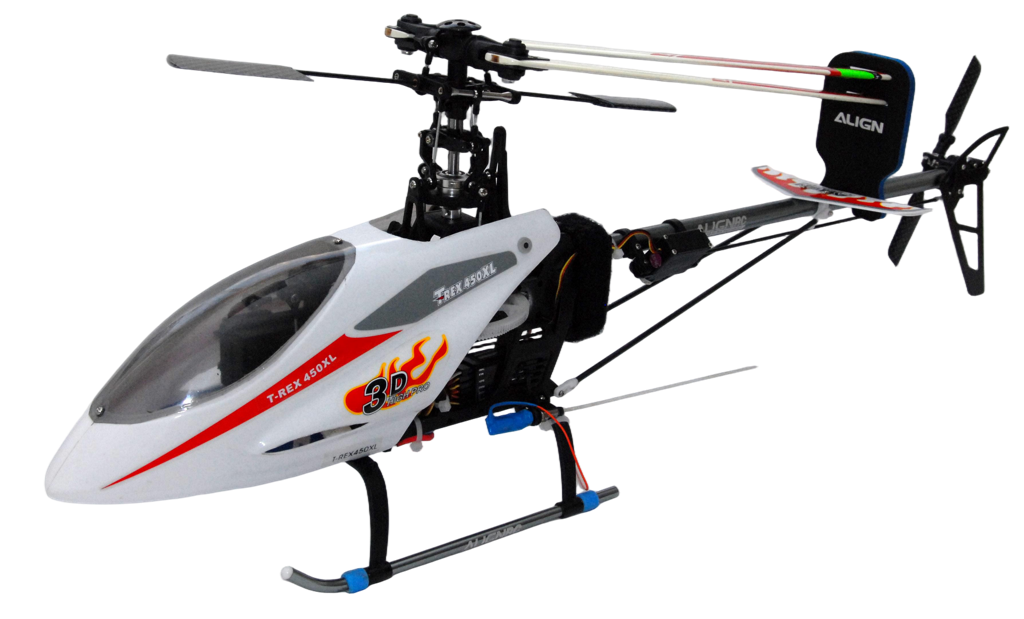

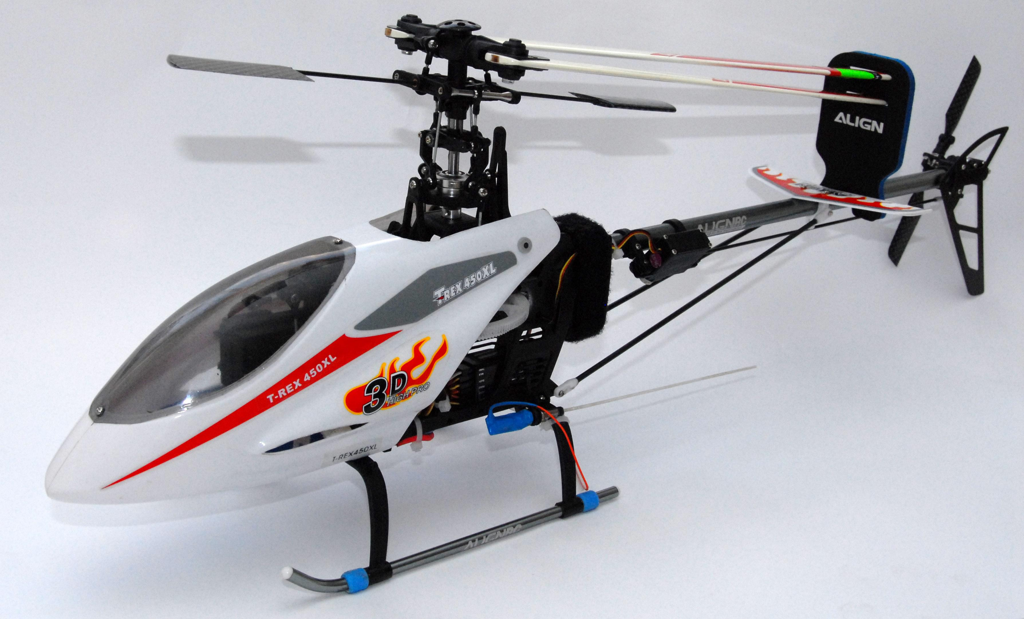

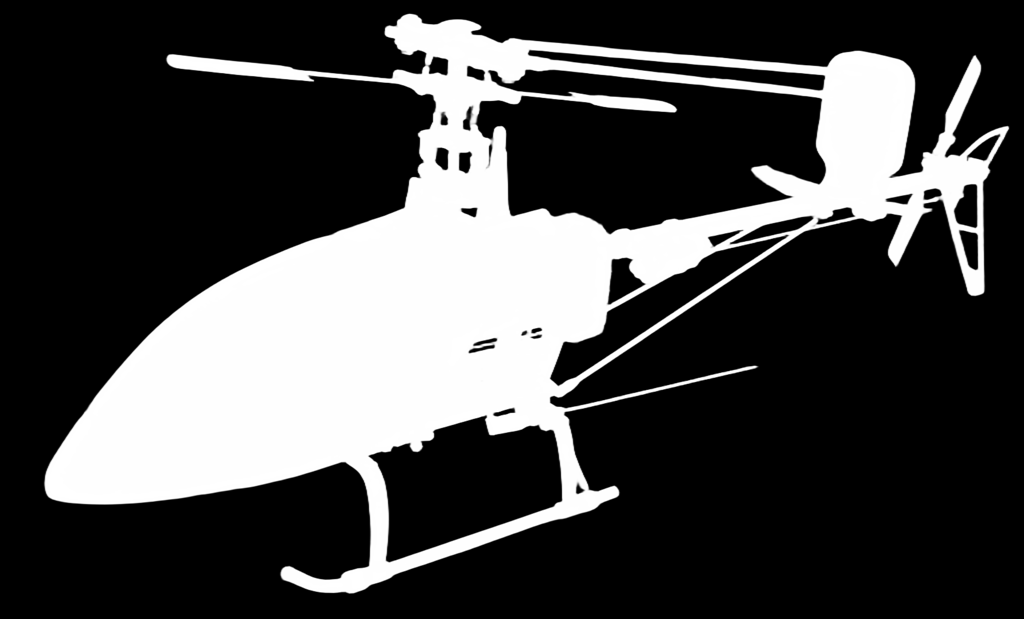

In [ ]:
import os
from glob import glob
from image_proc import refine_foreground

src_dir = '../images_todo'
image_paths = glob(os.path.join(src_dir, '*'))
dst_dir = '../predictions'
os.makedirs(dst_dir, exist_ok=True)
for image_path in image_paths:
    print('Processing {} ...'.format(image_path))
    image = Image.open(image_path)
    input_images = transform_image(image).unsqueeze(0).to('cuda')
    input_images = input_images.half()

    # Prediction
    with torch.no_grad():
        preds = birefnet(input_images)[-1].sigmoid().cpu()
    pred = preds[0].squeeze()

    # Save Results
    file_ext = os.path.splitext(image_path)[-1]
    pred_pil = transforms.ToPILImage()(pred)
    pred_pil = pred_pil.resize(image.size)
    pred_pil.save(image_path.replace(src_dir, dst_dir).replace(file_ext, '-mask.png'))
    image_masked = refine_foreground(image, pred_pil)
    image_masked.putalpha(pred_pil)
    image_masked.save(image_path.replace(src_dir, dst_dir).replace(file_ext, '-subject.png'))

# Visualize the last sample:
# Scale proportionally with max length to 1024 for faster showing
scale_ratio = 1024 / max(image.size)
scaled_size = (int(image.size[0] * scale_ratio), int(image.size[1] * scale_ratio))

display(image_masked.resize(scaled_size))
display(image.resize(scaled_size))
display(pred_pil.resize(scaled_size))

In [ ]:
# import requests
# from io import BytesIO


# image_url = "https://qph.cf2.quoracdn.net/main-qimg-d89362d538d350a4e4218a366e0d0425-pjlq"
# response = requests.get(image_url)
# image_data = BytesIO(response.content)
# image = Image.open(image_data)
# input_images = transform_image(image).unsqueeze(0).to('cuda')

# # Prediction
# with torch.no_grad():
#     preds = birefnet(input_images)[-1].sigmoid().cpu()
# pred = preds[0].squeeze()

# # Show Results
# pred_pil = transforms.ToPILImage()(pred)
# # Scale proportionally with max length to 1024 for faster showing
# scale_ratio = 1024 / max(image.size)
# scaled_size = (int(image.size[0] * scale_ratio), int(image.size[1] * scale_ratio))
# image_masked = image.resize((1024, 1024))
# image_masked.putalpha(pred_pil)
# display(image_masked.resize(scaled_size))
# display(image.resize(scaled_size))
# display(pred_pil.resize(scaled_size))